In [155]:
import pandas as pd
from sklearn import model_selection, preprocessing
pd.options.mode.chained_assignment = None  # default='warn'


In [172]:
dataset = pd.read_csv('./raw_data.csv')
length = len(dataset)
print("Total rows in dataset:",length)

Total rows in dataset: 20000


In [189]:
dataset.sort_values("description", inplace = True)
dataset.drop_duplicates(subset ="description",
                     keep = False, inplace = True)
print("duplicates found: ",length - len(dataset))


duplicates found:  3448


Number of Unique categories:

Women'sClothing                            0.197559
Jewellery                                  0.163001
Men'sClothing                              0.080715
Footwear                                   0.063920
Automotive                                 0.060778
                                             ...   
classyworldBrassCufflink(Silver-01)        0.000060
DisneyPrintedBabyBoy'sHoodedGreyT-Shirt    0.000060
ZikrakEximWomenWedges                      0.000060
StyleWorldWomenFlats                       0.000060
ImpalaAlloyCufflink(White)                 0.000060
Name: category, Length: 266, dtype: float64


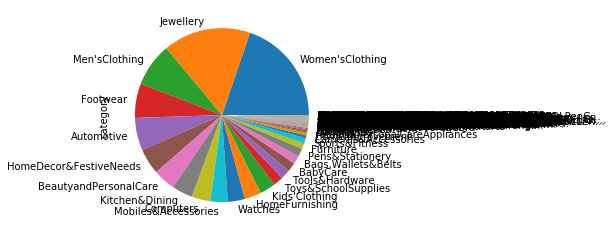

In [190]:
split_operation = lambda x:x.strip("[]").strip('\"').replace(" ","").strip().split(">>")
dataset["product_category_list"] = dataset["product_category_tree"].apply(split_operation)
assign = lambda x:x[0]
dataset["category"] = dataset["product_category_list"].apply(assign)
print("Number of Unique categories:\n")
for i in dataset.index:
    if dataset["category"][i] == "Clothing":
        dataset["category"][i] = dataset["product_category_list"][i][1]

counts = dataset["category"].value_counts(normalize = True)
counts.plot(kind = "pie")
print(counts)

From the above data, we can see that number of products from each category vary from as much as 7000 examples to as low as 1 examples. so we need to drop those categories from dataset which are low in number in our dataset. In the following cell, you can see that various categories with their corresponding number of examples in dataset.

In [195]:
# Select the values where the count is less than 3 (or 5 if you like)
to_remove = counts[counts <= 0.001].index
print("Categories with less than 20 examples:", len(to_remove))
to_remove = counts[counts <= 0.01].index
print("Categories with less than 200 examples:", len(to_remove))
to_remove = counts[counts <= 0.025].index
print("Categories with less than 500 examples:", len(to_remove))
to_remove = counts[counts <= 0.04].index
print("Categories with less than 800 examples:", len(to_remove))
to_remove = counts[counts <= 0.05].index
print("Categories with less than 1000 examples:", len(to_remove))
to_remove = counts[counts <= 0.1].index
print("Categories with less than 2000 examples:", len(to_remove))
to_remove = counts[counts <= 1].index
print("Total", len(to_remove))


Categories with less than 20 examples: 238
Categories with less than 200 examples: 246
Categories with less than 500 examples: 253
Categories with less than 800 examples: 259
Categories with less than 1000 examples: 261
Categories with less than 2000 examples: 264
Total 266


Women'sClothing           0.231685
Jewellery                 0.191158
Men'sClothing             0.094658
Footwear                  0.074961
Automotive                0.071277
HomeDecor&FestiveNeeds    0.055973
BeautyandPersonalCare     0.048746
Kitchen&Dining            0.045345
Computers                 0.040740
Mobiles&Accessories       0.037693
Watches                   0.037551
HomeFurnishing            0.036205
Kids'Clothing             0.034009
Name: category, dtype: float64


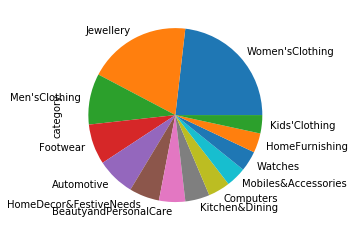

In [200]:
to_remove = counts[counts <= 0.025].index
data = dataset[~dataset.category.isin(to_remove)]
count_data = data["category"].value_counts(normalize = True)
print(count_data)
count_data.plot(kind = "pie")

In [201]:
all_columns = list(data.columns)
all_columns.remove('category')
all_columns.remove('description')
data = data.drop(all_columns,axis=1)

After we dropped lables with less than 500 examples, we are left with just 11 unique categories for our classifier. However, we can still see that our minimum and maximum examples for each category still differ by a lot. Hence, this dataset is still imbalanced. To solve this, we can use some undersampling or oversampling techniques. But before that, we will drop some columns and export our current dataset to try out tests on it later.

In [202]:
import re
import string
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.corpus import wordnet
import numpy as np
stop_words = set(stopwords.words('english')) 


preprocessed_data = data.copy()
preprocessed_data["pre_processed_text"] = np.nan
for index in preprocessed_data.index:
    desc = preprocessed_data["description"][index].lower()
    desc = re.sub(r'\d+', '', desc)
    desc = desc.translate(str.maketrans("","", string.punctuation))
    desc = desc.strip()
    word_tokens = word_tokenize(desc)
    preprocessed_data["description"][index] = (" ").join(word_tokens)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]   
    filtered_sentence = []   
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    preprocessed_data["pre_processed_text"][index] = (" ").join(filtered_sentence)

print(preprocessed_data)        

                                             description         category  \
8770   f solid womens tunic buy rust f solid womens t...  Women'sClothing   
15053  f checkered womens regular skirt buy red f che...  Women'sClothing   
295    dresses brown shiver me timbers boots buy dres...         Footwear   
12539  nd street womens self design casual shirt buy ...  Women'sClothing   
16370  carat lace up shoes price rs pure leather form...         Footwear   
...                                                  ...              ...   
19114  texclusive silk embroidered semistitched salwa...  Women'sClothing   
18958  tiwaritraders water jug l price rs pure copper...   Kitchen&Dining   
9873   urbantouch regular fit mens trousers price rs ...    Men'sClothing   
5503   youniqueshop plastic stainless steel hand juic...   Kitchen&Dining   
16123  zdelhicom car washer z ultra high pressure was...       Automotive   

                                      pre_processed_text  
8770   f solid w

In [203]:
preprocessed_data.to_csv('./datasets/imbalanced_dataset_500.csv',index=False)

converting English text to any random language and converting back to English using neural machine translation. 

In [134]:
# Failed Attempt

import random
from googletrans import Translator
import time
sr = random.SystemRandom()


def data_augmentation(translator, descriptions):
    languages = ["es", "de", "fr", "ar", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps"]
    lang = sr.choice(languages)
    ls = [descriptions]
    translations =  translator.translate(ls, dest = lang) ## Converting to random langauge for meaningful variation
    ls1 = []
    for t in translations:
        ls1.append(t.text)
    regen = translator.translate(ls1,  dest = "en")
    print(regen[0])
    return regen[0]


In [ ]:
print("Original Text:", preprocessed_data['description'][2])
txt = data_augmentation(translator,preprocessed_data['description'][2])[0]
print("Regenerated Text:", txt)
# if preprocessed_data['description'][0] == regen:
#     print(True)

In [71]:
augmented_dataset = pd.DataFrame()
augmented_dataset["pre_processed_text"] = np.nan
augmented_dataset["description"] = np.nan
augmented_dataset["category"] = np.nan

In [154]:
print(preprocessed_data.head())
unique_lables = list(preprocessed_data['category'].unique())
unique_lables.remove("Clothing")
unique_lables.remove("Jewellery")


labels = []
descriptions = []
for index in preprocessed_data.index:
    label = preprocessed_data["category"][index]
    desc = preprocessed_data["description"][index]
    desc.rstrip('\n')
    if label in unique_lables:
        labels.append(label)
        descriptions.append(desc)

with open('./datasets/data_to_augment.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(descriptions))

# length = len(descriptions)
# translator = Translator()
# translated_text = []
# for i in range(3428,len(descriptions)):
#     ls = list()
#     ls.append(descriptions[i])
#     result = data_augmentation(translator, ls)
#     translated_text.append(result[0])
#     if desc == result[0]:
#         print(True)
#     else:
#         print(False)
#     augmented_dataset = augmented_dataset.append({"description":result[0],
#                                                  "category":labels[i]},ignore_index=True)
#     print("Done with %d/%d example"%(i,length))
# augmented_dataset.to_csv('./datasets/augmented_dataset_500.csv',index=False)

                                             description  category  \
8770   f solid womens tunic buy rust f solid womens t...  Clothing   
15053  f checkered womens regular skirt buy red f che...  Clothing   
295    dresses brown shiver me timbers boots buy dres...  Footwear   
12539  nd street womens self design casual shirt buy ...  Clothing   
16370  carat lace up shoes price rs pure leather form...  Footwear   

                                      pre_processed_text  
8770   f solid womens tunic buy rust f solid womens t...  
15053  f checkered womens regular skirt buy red f che...  
295    dresses brown shiver timbers boots buy dresses...  
12539  nd street womens self design casual shirt buy ...  
16370  carat lace shoes price rs pure leather formal ...  


In [59]:
augmented_dataset.to_csv('./datasets/augmented_dataset_500.csv',index=False)
count_data = augmented_dataset["category"].value_counts()
print(count_data)

Automotive                684
BeautyandPersonalCare     521
Footwear                  439
HomeDecor&FestiveNeeds    405
Computers                 390
HomeFurnishing            295
Mobiles&Accessories       285
Kitchen&Dining            282
Watches                   128
Name: category, dtype: int64
